In [15]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# GPU 'cuda:0' if torch.cuda.is_available() else 
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


In [4]:
# Cifar-10 data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
# Data
batchSize = 32
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=0)
testLoader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Data classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
classes[0]

'plane'

In [8]:
# Model structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 卷積層1，3通道輸入，6個卷積核，核大小5*5
        self.conv2 = nn.Conv2d(6, 16, 5) # 卷積層2，6輸入通道，16個卷積核，核大小5*5
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# Parameters
criterion = nn.CrossEntropyLoss()
lr = 0.001
epochs = 50
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

In [11]:
# Train
for epoch in range(epochs):
    running_loss = 0.0

    for times, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if times % 100 == 99 or times+1 == len(trainLoader):
            print('[%d/%d, %d/%d] loss: %.3f' % (epoch+1, epochs, times+1, len(trainLoader), running_loss/len(trainLoader)))

print('Finished Training')

[1/50, 100/1563] loss: 0.122
[1/50, 200/1563] loss: 0.241
[1/50, 300/1563] loss: 0.359
[1/50, 400/1563] loss: 0.474
[1/50, 500/1563] loss: 0.588
[1/50, 600/1563] loss: 0.701
[1/50, 700/1563] loss: 0.813


KeyboardInterrupt: 

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

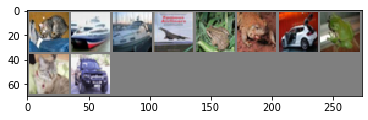

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


In [33]:
dataiter = iter(testLoader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:10]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [27]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batchSize)))

Predicted:    cat   car   car plane  deer  frog   dog  frog  deer   car  deer truck   dog horse truck  ship   cat horse  ship  frog horse plane  deer truck  deer truck   cat plane truck  frog   cat  bird


In [44]:
# Test
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test inputs: %d %%' % (100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testLoader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test inputs: 61 %
Accuracy of plane : 70 %
Accuracy of   car : 78 %
Accuracy of  bird : 44 %
Accuracy of   cat : 35 %
Accuracy of  deer : 58 %
Accuracy of   dog : 55 %
Accuracy of  frog : 65 %
Accuracy of horse : 69 %
Accuracy of  ship : 73 %
Accuracy of truck : 63 %


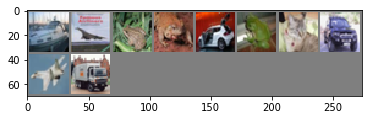

GroundTruth:   ship plane  frog  frog   car  frog   cat   car plane truck


In [19]:
# 5.1 randomly show 10 images and labels respectively.
def Q5_1():
    print('# 5.1 ...')
    dataiter = iter(testLoader)
    images, labels = dataiter.next()
    randIndex = random.randint(0,21)
    # print images
    imshow(torchvision.utils.make_grid(images[randIndex:randIndex + 10]))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[randIndex + j]] for j in range(10)))
Q5_1()

In [28]:
# 5.2 Print out training hyperparameters (batch size, learning rate, optimizer) 
def Q5_2():
    print('# 5.2 ...\nhyperparameters:\nbatch size: {}\nlearning rate: {}\noptimizer: {}'.format(batchSize, lr, optimizer.__class__.__name__))
Q5_2()

# 5.2 ...
hyperparameters:
batch size: 32
learning rate: 0.001
optimizer: SGD


# 5.3 ...
5.3 Finished Training
Plotting loss graph


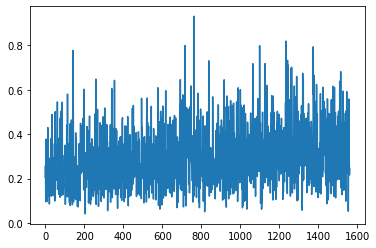

In [41]:
# 5.3 Train 1 epoch and show loss graph
def Q5_3():
    print('# 5.3 ...')
    running_loss = 0.0
    loss_history = []
    for times, data in enumerate(trainLoader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_history.append(loss.item())

    print('5.3 Finished Training\nPlotting loss graph')
    plt.plot(loss_history)
Q5_3()

In [38]:
epoch_loss_history = []
epoch_accuracy_history = []
def Q5_4():
    print('# 5.4 ...')
    # Train
    for epoch in range(epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        total_train = 0
        correct_train = 0
        train_accuracy = 0
        
        for times, data in enumerate(trainLoader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # loss
            running_loss += loss.item()
            
            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.nelement()
            correct_train += sum(predicted.eq(labels.data)).item()
            
        train_accuracy = 100 * correct_train / total_train
        epoch_loss = running_loss/len(trainLoader)
        
        epoch_accuracy_history.append(train_accuracy)
        epoch_loss_history.append(epoch_loss)
        
        print('[%d/%d] loss: %.3f accuracy:　%.3f' % (epoch+1, epochs, epoch_loss, train_accuracy))
    
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    print('Finished Training')
    
Q5_4()

# 5.4 ...
[1/50] loss: 1.088 accuracy:　61.356
[2/50] loss: 1.053 accuracy:　62.906
[3/50] loss: 1.024 accuracy:　64.030
[4/50] loss: 0.993 accuracy:　65.054
[5/50] loss: 0.966 accuracy:　66.072
[6/50] loss: 0.936 accuracy:　67.020
[7/50] loss: 0.911 accuracy:　68.156
[8/50] loss: 0.885 accuracy:　68.826
[9/50] loss: 0.861 accuracy:　69.898
[10/50] loss: 0.839 accuracy:　70.448
[11/50] loss: 0.820 accuracy:　71.106
[12/50] loss: 0.796 accuracy:　72.058
[13/50] loss: 0.775 accuracy:　72.932
[14/50] loss: 0.757 accuracy:　73.328
[15/50] loss: 0.742 accuracy:　73.654
[16/50] loss: 0.721 accuracy:　74.520
[17/50] loss: 0.700 accuracy:　75.318
[18/50] loss: 0.683 accuracy:　75.838
[19/50] loss: 0.670 accuracy:　76.276
[20/50] loss: 0.649 accuracy:　77.098
[21/50] loss: 0.635 accuracy:　77.588
[22/50] loss: 0.620 accuracy:　77.886
[23/50] loss: 0.602 accuracy:　78.672
[24/50] loss: 0.589 accuracy:　79.026
[25/50] loss: 0.574 accuracy:　79.674
[26/50] loss: 0.560 accuracy:　79.922
[27/50] loss: 0.545 accuracy:　80.716


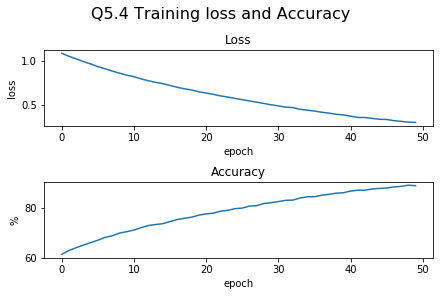

In [39]:
a = [0, 1, 2, 3, 4, 5]
b = [5, 4, 3, 2, 1, 0]

fig, axs = plt.subplots(2, 1, constrained_layout=True)
fig.suptitle('Q5.4 Training loss and Accuracy', fontsize=16)

axs[0].plot(epoch_loss_history)
axs[0].set_title('Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')

axs[1].plot(epoch_accuracy_history)
axs[1].set_title('Accuracy')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('%')

plt.show()

In [43]:
print(epoch_loss_history)
print(epoch_accuracy_history)

[1.0879884535543292, 1.053143036285426, 1.0241525327061052, 0.9928539135253208, 0.966357434627267, 0.9355499422176481, 0.9110697036321851, 0.8848814769425761, 0.8610663834437299, 0.838849550397901, 0.8204962368661292, 0.7963515725642233, 0.774685520900417, 0.7566149655970258, 0.741774560698926, 0.721135259589856, 0.7004990591044923, 0.6828266215759138, 0.6699947402100492, 0.649101364301781, 0.6350599001575874, 0.6202469776722382, 0.6016882511281235, 0.5893053744209934, 0.5739222370369345, 0.5598155571170442, 0.5449171715719304, 0.5310012372597928, 0.5161743458272247, 0.5009361059903641, 0.48895247681012766, 0.47451923980174426, 0.4688317228015691, 0.45018762614165675, 0.4402792865716717, 0.42976829234179365, 0.41665930494961645, 0.4062449321942076, 0.39300752066013833, 0.3867906306990049, 0.3713044564138981, 0.35756407255784717, 0.35598931109779397, 0.3464199471610979, 0.33616181796682393, 0.33404720781021824, 0.32043447228707495, 0.31266154245886374, 0.30342528852261724, 0.30053479224

In [143]:
def visualize_model(model, iters=1, index=0):
    images_so_far = 0
    fig = plt.figure()

    dataiter = iter(testLoader)
    
    if iters > 0:
        for i in range(0, iters):
            dataiter.next()
            
    images, labels = dataiter.next()
    images, labels = images.to(device), images.to(device)

    outputs = model(images)
    results = outputs.data[index].tolist()
    minR = min(results)
    maxR = max(results)
    diff = maxR-minR
    poResults = [ (i-minR)/diff for i in results]
    sumR = sum(poResults)
    denormResults = [i/sumR for i in poResults]

    _, preds = torch.max(outputs.data, 1)

    y_pos = np.arange(10)
    plt.bar(y_pos, denormResults, align='center', alpha=0.5)
    plt.xticks(y_pos, classes)
    plt.ylabel('Prob.')
    plt.title('Estimation result')

    plt.show()
    imshow(images.cpu().data[index])


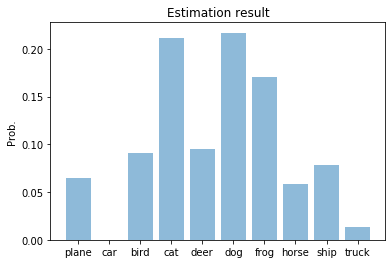

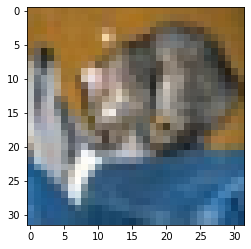

In [145]:
def Q5_5():
    num = 0
    iters = int(num/batchSize)
    index = num%batchSize
    if iters > 0 and index > 0:
        index = index - 1
    visualize_model(net, iters, index)
Q5_5()